In [ ]:
# Personal implementation of ASIF by Antonio Norelli (noranta4.com)
# PhD student in Computer Science, Sapienza University of Rome
# this notebook is released under MIT License

# ASIF demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/noranta4/ASIF/blob/main/ASIF_colab_demo.ipynb)

This is a self-contained notebook useful to
run ASIF models based on different backbones and datasets.

It includes several demos and is sufficient to reproduce the main results reported in the paper within minutes.

The free GPU runtime of colab is sufficient to run all the code, dataset embeddings are precomputed and downloaded from my google drive.

Paper: [*ASIF: Coupled Data Turns Unimodal Models to Multimodal Without Training*](https://arxiv.org/abs/2210.01738)

### Content

- Setup of the ASIF model
- DEMO1: Zero-shot classification experiment (Fig. 5 in the paper)
- DEMO2: Calculate the similarity between uploaded images and texts
- DEMO3: Interpretability demo: deep dive into a classification
- DEMO4: Universal classifier using images from your webcam

### Preparation for Colab

In [1]:
import gdown

!pip install --upgrade --no-cache-dir gdown
!git clone https://github.com/noranta4/ASIF.git
!mv /content/ASIF/* /content/
!pip install -r requirements.txt

Cloning into 'ASIF'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 42 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 6.61 MiB | 17.91 MiB/s, done.
Resolving deltas: 100% (17/17), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 57.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120734 sha256=f60be520e61b26fa4e6ea565a6c12a0ed3d57

## Setup of the ASIF model

An ASIF model is defined by two unimodal pretrained encoders $E_1, E_2$ and a collection of paired embeddings $D = \{(x_1, y_1), (x_2, y_2), (x_3, y_3), \dots \}$.

<img src="https://gladia.di.uniroma1.it/publication/norelli-2022-asif/featured_hu09e86fdd9d2db84095e78c3ccdc5c547_147325_720x2500_fit_q100_h2_lanczos_3.webp" alt="Image" width="400">

In this section, we'll load an image and a text encoder, and select a multimodal dataset containing paired embeddings. Let's dive in!

In [2]:
# @title imports

import os
import torch
import torchvision.transforms as transforms
from typing import Tuple, List, Type, Union
from sentence_transformers import SentenceTransformer
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTModel, ConvNextFeatureExtractor, ConvNextModel, AutoFeatureExtractor, DeiTModel
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.image as mpimg
import numpy as np
import gdown
import subprocess
from embdatasets import EmbeddedImagenet, EmbeddedCIFAR100, EmbeddedPETS, EmbeddedDataset, EmbeddedImagenetV2
import re
from PIL import Image
import pandas as pd
import seaborn as sns
import pickle

os.environ["TOKENIZERS_PARALLELISM"] = "false"  # avoid using parallel tokenizers for text transformers for conflicts with dataloaders with multiple workers
if not os.path.exists(f'example_images'): os.makedirs('example_images')
cc12m_drive_keys = {
        'VIT' : '1DxOX3_r7Iy5ylwIrSeCedmODadNc59ZO',
        'DINO': '1fpjscu-MMcqY8tDEHrAtU8nllL5eVMKu',
        'DEITtiny': '1pKa4YIyfUgYRf0DWyQRnMnaOAmPCzRBL',
        'DEITmedium': '1tpqO8145VQVoVVK26Rg7osCRd6zbWnqQ',
        'DEITlarge': '1-3cxQmlvMlU3AyTdKjBOdrp9WMuwBXvm',
        'SentenceT' : '1nBnD1EmrdErj40ya4R1HfplDGrqRBP2j',
        'SentenceTmini' : '1IoHM4SVB9ibsTPWSo42_HVvz_s4CocqB',
        'SentenceTmedium' : '1sRh2RteUre2NFqW_-2suGitVou7dZ2TC',
        'Metadata' : '1hLQQdIP_GVFz85CtYb9ZDVyNu20OdEcu',
    }

/usr/local/lib/python3.10/dist-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(


### ASIF core code

Here I exposed the code implementing the ASIF idea so that you can play with it.

Alternatively you can just run the following cell.

In [ ]:
# from relreps import MemoryTensor, zero_shot_classification, rand_mul_indices

In [22]:
# utilities to compute the relative representations and store them in sparse tensors and to manage tensors larger than RAM

from typing import Tuple, List, Type, Union
import torch
from tqdm import tqdm


def relative_represent(y: torch.Tensor, basis: torch.Tensor, non_zeros: int = 800, max_gpu_mem_gb: int = 8) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the sparse decomposition of a tensor y with respect to a basis,
    considering the available GPU memory.

    Args:
        y (torch.Tensor): Vectors to represent.
        basis (torch.Tensor): Basis to represent with respect to.
        non_zeros (int): Nonzero entries in the relative representation.
        max_gpu_mem_gb (int): Maximum GPU memory allowed to use in gigabytes.

    Returns:
        indices (torch.Tensor): Indices of the nonzero entries in each relative representation of y.
        values (torch.Tensor): Corresponding coefficients of the entries.
    """
    # values, indices = torch.zeros((y.shape[0], non_zeros)), torch.zeros((y.shape[0], non_zeros), dtype=torch.long)
    # 新修改
    device = y.device  # 获取 y 张量所在的设备
    values, indices = torch.zeros((y.shape[0], non_zeros), device=device), torch.zeros((y.shape[0], non_zeros), dtype=torch.long, device=device)
    basis = basis.to(device)

    free_gpu_mem = max_gpu_mem_gb * 1024 ** 3
    max_floats_in_mem = free_gpu_mem / 4
    max_chunk_y = max_floats_in_mem / basis.shape[0]
    n_chunks = int(y.shape[0] / max_chunk_y) + 1
    chunk_y = int(y.shape[0] / n_chunks) + n_chunks

    with torch.no_grad():
        for c in range(n_chunks):
            in_prods = torch.einsum('ik, jk -> ij', y[c * chunk_y : (c + 1) * chunk_y], basis)

            # 检查 in_prods 的大小，确保不会超出范围
            actual_non_zeros = min(in_prods.size(1), non_zeros)  # 保证获取的 top-k 不超过实际大小
            values[c * chunk_y : (c + 1) * chunk_y], indices[c * chunk_y : (c + 1) * chunk_y] = torch.topk(in_prods, actual_non_zeros, dim=1)

            del in_prods

    return indices.to('cpu'), values.to('cpu')


def sparsify(i: torch.Tensor, v: torch.Tensor, size: torch.Size) -> torch.sparse.FloatTensor:
    """
    Organize indices and values of n vectors into a single sparse tensor.

    Args:
        i (torch.Tensor): indices of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        v (torch.Tensor): values of non-zero elements of every vector. Shape: (n_vectors, nonzero elements)
        size (torch.Size): shape of the output tensor

    Returns:
        torch.sparse.FloatTensor: sparse tensor of shape "size" (n_vectors, zero + nonzero elements)
    """
    flat_dim = len(i.flatten())
    coo_first_row_idxs = torch.div(torch.arange(flat_dim), i.shape[1], rounding_mode='floor')
    stacked_idxs = torch.cat((coo_first_row_idxs.unsqueeze(0), i.flatten().unsqueeze(0)), 0)
    return torch.sparse_coo_tensor(stacked_idxs, v.flatten(), size)


def normalize_sparse(tensor: torch.sparse.FloatTensor, nnz_per_row: int) -> torch.sparse.FloatTensor:
    """
    Normalize a sparse tensor by row.

    Args:
        tensor (torch.sparse.FloatTensor): The sparse tensor to normalize.
        nnz_per_row (int): The number of non-zero elements per row.

    Returns:
        torch.sparse.FloatTensor: The normalized sparse tensor.
    """
    norms = torch.sparse.sum(tensor * tensor, dim=1).to_dense()
    v = tensor._values().clone().detach().reshape(-1, nnz_per_row).t()
    v /= torch.sqrt(norms)
    return torch.sparse_coo_tensor(tensor._indices(), v.t().flatten(), tensor.shape)


class MemoryTensor:
    """
    Class to load tensors from disk in chunks and store them in memory.
    """
    def __init__(self, ordered_filepaths: List[str], chunk_size: int = 100_000, device: str = 'cuda', normalized=True) -> None:
        """
        Args:
            ordered_filepaths (List[str]): list of filepaths to load tensors from
            chunk_size (int): size of chunks to load from disk
            device (str): device to load tensors to
            normalized (bool): whether dim1 of the tensor should be normalized to norm=1
        """
        self.paths = ordered_filepaths
        self.chunk_size = chunk_size
        if normalized:
            for i, fp in enumerate(ordered_filepaths):
                tmp = torch.load(fp).to(device)
                if i == 0:  # if first chunk is already normalized, assume everything is normalized
                    tmp_sum = torch.einsum('ik ->', tmp * tmp)
                    if tmp_sum - tmp.shape[0] < 0.01 * tmp.shape[0]:
                        break # if already normalized break (1% error tolerated)
                tmp /= torch.einsum('ik -> i', tmp * tmp).unsqueeze(1) ** 0.5
                torch.save(tmp, fp)
            del tmp
        self.chunk_in_memory = 0
        self.x = torch.load(self.paths[-1]).to(device)
        self.device = device
        self.len = self.chunk_size * (len(self.paths) - 1) + len(self.x)
    def __getitem__(self, index: Union[int, slice, torch.Tensor]) -> torch.Tensor:
        """
        Args:
            index (Union[int, slice, torch.Tensor]): index to get item from
        Returns:
            torch.Tensor: tensor at index
        """
        if isinstance(index, int):
            chunk = index // self.chunk_size
            if chunk != self.chunk_in_memory:
                self.chunk_in_memory = chunk
                self.x = torch.load(self.paths[chunk]).to(self.device)
            return self.x[index % self.chunk_size]
        if isinstance(index, slice):
            start = index.start
            stop = index.stop
            if start is None:
                start = 0
            if stop is None:
                stop = len(self)
            c_start = start // self.chunk_size
            if stop >= self.len:
                stop = self.len - 1
            c_stop = stop // self.chunk_size
            if c_start == c_stop:
                if c_start != self.chunk_in_memory:
                    self.chunk_in_memory = c_start
                    self.x = torch.load(self.paths[c_start]).to(self.device)
                return self.x[start % self.chunk_size : stop % self.chunk_size]
            elif c_start + 1 == c_stop:
                if c_start != self.chunk_in_memory:
                    self.chunk_in_memory = c_start
                    self.x = torch.load(self.paths[c_start]).to(self.device)
                temp = self.x[start % self.chunk_size :]
                self.chunk_in_memory = c_stop
                self.x = torch.load(self.paths[c_stop]).to(self.device)
                return torch.cat((temp, self.x[:stop % self.chunk_size]), dim=0)
            else:
                raise Exception("slice too big (bigger than chunk size)")
        if isinstance(index, torch.Tensor):
            chunk = index.flatten()[0] // self.chunk_size
            if chunk != self.chunk_in_memory:
                self.chunk_in_memory = chunk
                self.x = torch.load(self.paths[chunk]).to(self.device)
            return self.x[index % self.chunk_size]

    def __len__(self) -> int:
        """
        Returns:
            int: length of tensor
        """
        return self.len



def zero_shot_classification(zimgs: torch.Tensor, ztxts: torch.Tensor, aimgs: torch.Tensor, atxts: torch.Tensor, non_zeros: int, range_anch: range, val_exps: list, dic_size: int = 100_000, max_gpu_mem_gb: float = 8.) -> (list, torch.Tensor):
    """
    Computes the zero-shot classification by finding the most similar texts to each image,
    over sets of anchors of different sizes and raising the similarities to the given exponents.
    计算零样本分类，通过找出与每张图像最相似的文本，基于不同大小的锚点集进行相似度计算，同时对相似度进行幂次调整。

    Args:
        zimgs (torch.Tensor): absolute embeddings of the images 待分类图像的绝对嵌入张量
        ztxts (torch.Tensor): absolute embeddings of the texts 结果文本空间的绝对嵌入张量
        aimgs (torch.Tensor): absolute embeddings of the anchor images 锚点图像的绝对嵌入张量
        atxts (torch.Tensor): absolute embeddings of the anchor texts 锚点文本的绝对嵌入张量

        non_zeros (int): nonzero entries in the relative representation 相对表示中的非零元素数量 k(最大的 k 个元素)
        range_anch (range): range of sizes of the anchor's sets to use (overshoot is ok) 选取的锚点数量序列, [ number of anchors ], 如[2^m, 2^(m + 1), ……, 2^n]
        val_exps (list): similarity exponents to test 要测试的相似度幂次列表, 如 [ 1, 3, 8]

        dic_size (int): size of the chunk of aimgs to load in memory to fit all intermediate variables in RAM 加载到内存中的锚定图像块的大小，默认为100,000

    Returns:
        n_anchors (list): list of sizes of the anchor's sets (with overshooting fixed) 锚点集大小的列表（经过修正后的大小）
        best_text_idx (torch.Tensor): tensor of the indices of the most similar texts for each image 每张图像最相似文本的索引列表
    """
    n_anchors = []  # 用于记录不同锚点集大小
    best_text_idx = []  # 用于存储每张图像最相似文本的索引
    device = zimgs.device  # 获取 zimgs 的设备类型，确保所有张量都在同一设备

    for i in tqdm(range_anch, position=0, leave=True):  # i: 选取的锚点数
        sims = torch.zeros((len(zimgs), len(ztxts)), device=device)  # 确保 sims 张量在正确的设备上
        idxs_imgs = torch.zeros((len(zimgs), non_zeros * 2), dtype=torch.long, device=device)  # 同上
        idxs_txts = torch.zeros((len(ztxts), non_zeros * 2), dtype=torch.long, device=ztxts.device)  # 同上
        vals_imgs = torch.zeros((len(zimgs), non_zeros * 2), device=device)  # 同上
        vals_txts = torch.zeros((len(ztxts), non_zeros * 2), device=ztxts.device)  # 同上

        # 分块处理锚点图像和文本
        for d in range(min(len(aimgs), i) // (dic_size + 1) + 1):  # d 表示当前正在处理的批次数
            # 对于每个批次 d, 在前 non_zeros 列 ([:non_zeros]) 位置填入该批次计算得到的 top-k (这里的 k 即 non_zeros) 最大相似度值及其对应索引
            idxs, values = relative_represent(zimgs, aimgs[d * dic_size : min(i, (d + 1) * dic_size)], non_zeros=non_zeros, max_gpu_mem_gb=max_gpu_mem_gb)
            idxs_imgs[:, :non_zeros] = idxs + d * dic_size  # 转换为全局索引
            vals_imgs[:, :non_zeros] = values

            idxs, values = relative_represent(ztxts, atxts[d * dic_size : min(i, (d + 1) * dic_size)], non_zeros=non_zeros, max_gpu_mem_gb=max_gpu_mem_gb)
            idxs_txts[:, :non_zeros] = idxs + d * dic_size  # 转换为全局索引
            vals_txts[:, :non_zeros] = values

            # 更新全局 top-k 结果
            top_valsi, indices = torch.topk(vals_imgs, non_zeros, dim=1)  # 最大的 k 个相似度值和这些值对应的 indices
            top_idxsi = torch.gather(idxs_imgs, 1, indices)  # 根据给定的 indices，从 idxs_imgs 中按指定维度（这里是第 1 维，即列）选择特定的元素
            top_valst, indices = torch.topk(vals_txts, non_zeros, dim=1)
            top_idxst = torch.gather(idxs_txts, 1, indices)

            idxs_imgs[:, non_zeros:] = top_idxsi
            vals_imgs[:, non_zeros:] = top_valsi
            idxs_txts[:, non_zeros:] = top_idxst
            vals_txts[:, non_zeros:] = top_valst

        # 处理每个相似度幂次 (val_exps)
        for val_exp in val_exps:
            # 确保 ztxts_t 和 zimgs_t 在同一设备上
            ztxts_t = sparsify(top_idxst, top_valst ** val_exp, (len(ztxts), min(len(aimgs), i))).to(device)  # 确保在正确的设备上
            ztxts_t = normalize_sparse(ztxts_t, non_zeros)

            # 检查 ztxts_t 和 zimgs_t 的设备
            print(f"ztxts_t device: {ztxts_t.device}")
            zimgs_t = sparsify(top_idxsi, top_valsi ** val_exp, (len(zimgs), min(len(aimgs), i))).to(device)  # 确保在正确的设备上
            print(f"zimgs_t device: {zimgs_t.device}")

            # 这里检查所有参与计算的张量的设备
            if zimgs_t.device != ztxts_t.device:
                raise RuntimeError("zimgs_t and ztxts_t are on different devices!")

            if i < max_gpu_mem_gb * 1024 ** 3 / 4 / zimgs.shape[0]:  # einsum until it fits in GPU memory
                sims = torch.einsum('ij, kj -> ik', zimgs_t.to_dense(), ztxts_t.to_dense())  # 保持在同一设备上
            else:  # 分块处理
                n_chunks = 6
                zs = zimgs.shape[0]
                chunks = [c * (zs // n_chunks) for c in range(n_chunks)] + [zs]
                for ci in range(n_chunks):
                    zimgs_t = sparsify(top_idxsi[chunks[ci]:chunks[ci+1]], top_valsi[chunks[ci]:chunks[ci+1]] ** val_exp, (chunks[ci+1] - chunks[ci], min(len(aimgs), i))).to(device)  # 确保在正确的设备上
                    sims[chunks[ci]:chunks[ci+1]] = torch.sparse.mm(zimgs_t, ztxts_t.t()).to(device).to_dense()  # 保持在同一设备上

            # 获取每张图像最相似的文本的索引
            best_text_idx.append(sims.argmax(axis=1))  # 每张图像最相似文本的索引

        n_anchors.append(min(len(aimgs), i))  # min(锚点总数, 选取的锚点数)

    # 返回最相似文本的索引
    return n_anchors, torch.cat(best_text_idx, dim=0)  # 返回所有图像最相似文本的索引




def rand_mul_indices(indices_list: List[int], n_templates: int) -> torch.Tensor:
    """Returns a tensor containing randomly generated indices, based on the input indices_list and n_templates.

    Args:
        indices_list (List[int]): A list of integers representing the starting indices.
        n_templates (int): An integer representing the number of templates.

    Returns:
        torch.Tensor: A tensor containing randomly generated indices.
    """
    x = torch.randint(low=0, high=len(n_templates), size=(len(indices_list),))
    return torch.tensor(indices_list) * len(n_templates) + x

### Choose the two encoders for the ASIF model

You can choose a preset encoder implemented in the cell right below, or implement your custom encoder.

In [4]:
# @title Visual and text encoders classes

class VIT():
    """
    Supervised image encoder based on the original ViT model from Google.
    """
    def __init__(self, model_name: str = 'google/vit-base-patch16-224-in21k', device: str = None, load_jit=True):
        """
        Args:
            model_name: name of the pretrained model to use
            device: device to use for inference
            load_jit: load model just in time (in the encode method)
        """
        if not device:
            self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        self.load_jit = load_jit
        self.model_name = model_name
        if self.model_name == 'google/vit-base-patch16-224-in21k':
            self.embedding_size = 768  # to be faster if embeddings are precomputed
        if not self.load_jit or self.model_name != 'google/vit-base-patch16-224-in21k':
            self.feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
            self.model = ViTModel.from_pretrained(model_name).to(self.device)
            self.embedding_size = self.model(torch.zeros(1, 3, 224, 224).to(self.device)).last_hidden_state[:,0,:].shape[1]  # 768

    def encode(self, images: torch.Tensor, alr_preprocessed: bool = False) -> torch.Tensor:
        """
        Args:
            images: images to encode
            alr_preprocessed: whether the images are already preprocessed to tensors
        Returns:
            image embeddings
        """
        if self.load_jit:
            self.feature_extractor = ViTFeatureExtractor.from_pretrained(self.model_name)
            self.model = ViTModel.from_pretrained(self.model_name).to(self.device)
            self.embedding_size = self.model(torch.zeros(1, 3, 224, 224).to(self.device)).last_hidden_state[:,0,:].shape[1]  # 768
            self.load_jit = False  # we load the model a single time
        with torch.no_grad():
            if not alr_preprocessed:
                x = self.feature_extractor(images=images, return_tensors="pt").to(self.device)
                x = self.model(**x)
            else:
                x = self.model(images.to(self.device))
            x = x.last_hidden_state[:,0,:]
        return x  # taking the embedding of the CLS token as image representation


class DINO():
    """
    Unsupervised image encoder using the DINO model from Meta Research.
    """

    def __init__(self, model_name: str = 'dino_vits8', device: str = None, load_jit=True):
        """
        Args:
            model_name: name of the model to use: dino_vit{"s"mall or "b"ase}{"8" or "16" patch size}
            device: device to use.
            load_jit: load model just in time (in the encode method)
        """
        if not device:
            self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        self.load_jit = load_jit
        self.model_name = model_name
        if self.model_name == 'dino_vits8':
            self.embedding_size = 384
        if not self.load_jit or self.model_name != 'dino_vits8':
            self.model = torch.hub.load('facebookresearch/dino:main', model_name)
            self.model = self.model.to(self.device)
            self.model.eval()
            self.embedding_size = self.model(torch.zeros(1, 3, 224, 224).to(self.device)).shape[1]  # 768

    def encode(self, images: torch.Tensor, alr_preprocessed: bool = True) -> torch.Tensor:
        """
        Args:
            images: images to encode.
            alr_preprocessed: if True, the images are already preprocessed.
        Returns:
            encoded images.
        """
        if self.load_jit:
            self.model = torch.hub.load('facebookresearch/dino:main', self.model_name)
            self.model = self.model.to(self.device)
            self.model.eval()
            self.embedding_size = self.model(torch.zeros(1, 3, 224, 224).to(self.device)).shape[1]  # 768
            self.load_jit = False  # we load the model a single time
        if not alr_preprocessed:
            preprocess = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # assuming imagenet mean and val
                                            transforms.Resize((224, 224))])
            images = torch.stack([preprocess(image) for image in images])
        with torch.no_grad():
            images = self.model(images.to(self.device))
        return images  # taking the embedding of the CLS token as image representation


class DEIT():
    """
    Supervised image encoder based on the DEIT model from Meta (Visual Transformer).
    """
    def __init__(self, model_name: str = 'facebook/deit-tiny-distilled-patch16-224', device: str = None):
        """
        Args:
            model_name: name of the pretrained model to use
            device: device to use for inference
        """
        if not device:
            self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        else:
            self.device = device
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.model = DeiTModel.from_pretrained(model_name).to(self.device)
        self.embedding_size = self.model(torch.zeros(1, 3, 224, 224).to(self.device)).last_hidden_state[:,0,:].shape[1]  # 768

    def encode(self, images: torch.Tensor, alr_preprocessed: bool = False) -> torch.Tensor:
        """
        Args:
            images: images to encode
            alr_preprocessed: whether the images are already preprocessed to tensors
        Returns:
            image embeddings
        """
        with torch.no_grad():
            if not alr_preprocessed:
                x = self.feature_extractor(images=images, return_tensors="pt").to(self.device)
                x = self.model(**x)
            else:
                x = self.model(images.to(self.device))
            x = x.last_hidden_state[:,0,:]
        return x


class DEITmedium(DEIT):
    def __init__(self, model_name: str='facebook/deit-small-distilled-patch16-224', device: str='cuda', load_jit=False) -> None:
        super().__init__(model_name)

class DEITlarge(DEIT):
    def __init__(self, model_name: str='facebook/deit-base-distilled-patch16-224', device: str='cuda', load_jit=False) -> None:
        super().__init__(model_name)


class SentenceT():
    """
    Unsupervised text encoder known as SentenceT. This class wraps the sentence-transformers library.
    """

    def __init__(self, model_name: str='sentence-transformers/all-mpnet-base-v2', device: str='cuda', load_jit=True) -> None:
        """
        Args:
            model_name (str): The name of the model to use.
            device (str): The device to use.
        """
        self.device = device
        self.load_jit = load_jit
        self.model_name = model_name
        if self.model_name == 'sentence-transformers/all-mpnet-base-v2':
            self.embedding_size = 768  # lazy default, if not load_jit we compute it
        if not self.load_jit or self.model_name != 'sentence-transformers/all-mpnet-base-v2':
            self.model = SentenceTransformer(model_name, device=self.device).eval()
            self.text_encoder = self.model.encode
            self.embedding_size = self.text_encoder(["Chi vuol esser lieto, sia: di doman non c'è certezza"], show_progress_bar=False).shape[1]

    def encode(self, texts: List[str]) -> torch.Tensor:
        """
        Args:
            texts (List[str]): A list of texts to encode.

        Returns:
            torch.Tensor: A tensor of shape (len(texts), 768)
        """
        if self.load_jit:
            print('loading encoder now...')
            self.model = SentenceTransformer(self.model_name, device=self.device).eval()
            self.text_encoder = self.model.encode
            self.embedding_size = self.text_encoder(["Chi vuol esser lieto, sia: di doman non c'è certezza"], show_progress_bar=False).shape[1]
            self.load_jit = False  # we load the model a single time
        ztxts = self.text_encoder(texts, show_progress_bar=False)
        return torch.tensor(ztxts).to(self.device)


class SentenceTmini(SentenceT):
    def __init__(self, model_name: str='sentence-transformers/all-MiniLM-L6-v2', device: str='cuda', load_jit=False) -> None:
        super().__init__(model_name, device, load_jit)

class SentenceTmedium(SentenceT):
    def __init__(self, model_name: str='sentence-transformers/all-MiniLM-L12-v2', device: str='cuda', load_jit=False) -> None:
        super().__init__(model_name, device, load_jit)


class CustomImageEncoder():
    def __init__(self):
        raise NotImplementedError

    def encode(self, images):
        raise NotImplementedError


class CustomTextEncoder():
    def __init__(self):
        raise NotImplementedError

    def encode(self, texts):
        raise NotImplementedError

In [5]:
encoders = {
    'VIT': VIT,
    'DINO': DINO,
    'DEIT': DEIT,
    'DEITmedium' : DEITmedium,
    'DEITlarge' : DEITlarge,
    'SentenceT' : SentenceT,
    'SentenceTmini' : SentenceTmini,
    'SentenceTmedium' : SentenceTmedium,
    'Custom_Image_Encoder' : CustomImageEncoder,
    'Custom_Text_Encoder' : CustomTextEncoder,
}

select_image_encoder = 'VIT (supervised pretraining on Im21k)' #@param ["VIT (supervised pretraining on Im21k)", "DINO (unsupervised pretraining on Im21k)", "DEIT (supervised pretraining on Im1k, tiny VIT)", "DEITmedium (supervised pretraining on Im1k, small VIT)", "DEITlarge (supervised pretraining on Im1k, base VIT)", "Custom_Image_Encoder"]
select_text_encoder = 'SentenceT (all-mpnet-base-v2)' #@param ["SentenceT (all-mpnet-base-v2)", "SentenceTmini (all-MiniLM-L6-v2)", "SentenceTmedium (all-MiniLM-L12-v2)", "Custom_Text_Encoder"]

image_encoder = encoders[select_image_encoder.split()[0]]()
text_encoder = encoders[select_text_encoder.split()[0]]()

### Choose the multimodal dataset to align relative representations


The larger and more varied the dataset, the more comprehensive the visual understanding of your ASIF model.

You can choose a preset multimodal dataset, or implement your own. If you use a classification dataset such as ImageNet as multimodal dataset, labels will be converted to captions through templates like "*a picture of a* {CLASS}".

In [6]:
# @title Custom dataset (edit this class if you want to use your custom dataset for training or test)

class EmbeddedCustomDataset(EmbeddedDataset):
    """
    Custom dataset loader. It is tailored on standard classification datasets,
    so it expects labeled images and builds captions using templates.
    """
    def __init__(self, classes: List[str] = None, templates: List[str] = None, subsample_size: int = 10_000, sampler_seed: int = 42, load_precomputed_embeddings=False, split = 'test'):
        """
        Args:
            classes: a list of classes, like ["tench", "goldfish", ...
            templates: a list of templates to craft captions using classes, like ['itap of a {}.', 'a bad photo of the {}.', ...
            subsample_size: how much images of the dataset you want to use. (they will be sampled randomly)
            sampler_seed: the seed for the random sampler.
        """
        ####### YOUR CODE HERE ########
        self.classes = classes  # define here the list of classes to not pass them to the constructor
        if not templates: self.templates = [  # if your dataset is already in the form of free text as CC12M, pass texts to classes and use ['{}'] as templates
            'itap of a {}.',
            'a bad photo of the {}.',
            'a origami {}.',
            'a photo of the large {}.',
            'a {} in a video game.',
            'art of the {}.',
            'a photo of the small {}.',
        ]
        self.texts = [
            prompt.format(classname)
            for classname in self.classes
            for prompt in self.templates
        ]
        self.load_precomputed = load_precomputed_embeddings
        self.subsample_size = subsample_size
        self.split = ''
        if not self.load_precomputed:
            preprocess = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Imagenet mean and std, fill with mean and std of your custom dataset
                                            transforms.Resize((224, 224))])
            ####### YOUR CODE HERE ########
            # load here your pytorch dataset, look at the PETS example
            images = None # datasets.OxfordIIITPet(root='pets', transform=preprocess, split={'Train' : 'trainval', 'Test' : 'test'}[split], download=True)
            self.loader = torch.utils.data.DataLoader(images, batch_size=100, num_workers=4)

You may mix a small dataset with the first 1.6M images of CC12M by checkmarking `integrate_with_CC12M`

In [24]:
# 假设已编码的图像和文本嵌入文件
imgs_anchor_path = 'Anchor/imgs_anchor'
txts_anchor_path = 'Anchor/txts_anchor'

available_datasets = {
    'CC12M (1.5M image-caption couples, precomputed)': False,
    'ImageNet val full': (EmbeddedImagenet, 'full', False),
    'ImageNet val split1 (precomputed)': (EmbeddedImagenet, 'Val', True),
    'ImageNet val split2 (precomputed)': (EmbeddedImagenet, 'Test', True),
    'CIFAR100' : (EmbeddedCIFAR100, 'Test', False),
    'PETS' : (EmbeddedPETS, 'Test', False),
    'ImageNetV2' : (EmbeddedImagenetV2, '', False),
    'CustomDataset': (EmbeddedCustomDataset, '', False)
}

select_train_dataset = 'CustomDataset' #@param ["CC12M (1.5M image-caption couples)", "ImageNet val split1 (precomputed)", "ImageNet val split2 (precomputed)", "CIFAR100", "PETS", "ImageNetV2", "CustomDataset"]
integrate_with_CC12M = True #@param {type:"boolean"}

if select_train_dataset[:5] != 'CC12M':
    '''
    train_dataset_class, split, load_precomputed_embeddings = available_datasets[select_train_dataset]
    train_dataset = train_dataset_class(split=split, load_precomputed_embeddings=load_precomputed_embeddings)
    aimgs, atxts, atest_labels = train_dataset.embed(image_encoder, text_encoder)
    atxts = atxts[rand_mul_indices(atest_labels, train_dataset.templates)]
    # normalization to perform cosine similarity with a simple matmul
    aimgs /= torch.einsum('ik -> i', aimgs * aimgs).unsqueeze(1) ** 0.5
    atxts /= torch.einsum('ik -> i', atxts * atxts).unsqueeze(1) ** 0.5
    '''
    # 加载已编码的 imgs_anchor 和 txts_anchor
    aimgs_anchor = torch.load(imgs_anchor_path)
    atxts_anchor = torch.load(txts_anchor_path)

    # 确保嵌入的维度是兼容的，可能需要在某些情况下进行归一化
    aimgs_anchor /= torch.einsum('ik -> i', aimgs_anchor * aimgs_anchor).unsqueeze(1) ** 0.5
    atxts_anchor /= torch.einsum('ik -> i', atxts_anchor * atxts_anchor).unsqueeze(1) ** 0.5
    if integrate_with_CC12M:
        torch.save(aimgs_anchor, 'aimgs.pt')
        torch.save(atxts_anchor, 'atxts.pt')

if select_train_dataset[:5] == 'CC12M' or integrate_with_CC12M:
    aimgs_paths, atxts_paths = [], []
    i = 0
    im_enc_name = select_image_encoder.split()[0]
    tx_enc_name = select_text_encoder.split()[0]

    for enc_name in [im_enc_name, tx_enc_name]:
        if not os.path.exists(f'EmbeddedCC12M{enc_name}'):
            key = cc12m_drive_keys[enc_name]
            file_name = f'EmbeddedCC12M{enc_name}.tar'
            print(f'Downloading and loading CC12M {enc_name} embeddings will take between 1 and 3 minutes')
            gdown.download('https://drive.google.com/uc?id=' + key, file_name, quiet=False)
            print(f'extracting {file_name}...')
            subprocess.call(f"tar -xf {file_name}", shell=True)
            # subprocess.call(['7z', 'x', f'EmbeddedCC12M{enc_name}.7z'])

    while (os.path.exists(f'EmbeddedCC12M{im_enc_name}/zimgs_{im_enc_name}_{i:04d}.pt') and
        os.path.exists(f'EmbeddedCC12M{tx_enc_name}/ztexts_{tx_enc_name}_{i:04d}.pt')):
        aimgs_paths.append(f'EmbeddedCC12M{im_enc_name}/zimgs_{im_enc_name}_{i:04d}.pt')
        atxts_paths.append(f'EmbeddedCC12M{tx_enc_name}/ztexts_{tx_enc_name}_{i:04d}.pt')
        i += 1

    if integrate_with_CC12M and select_train_dataset[:5] != 'CC12M':
        aimgs_paths.append('aimgs.pt')
        atxts_paths.append('atxts.pt')

    aimgs = MemoryTensor(aimgs_paths, chunk_size=100_000)
    atxts = MemoryTensor(atxts_paths, chunk_size=100_000)

    '''
    # 加载 CC12M 数据集的嵌入
    aimgs_cc12m = MemoryTensor(aimgs_paths, chunk_size=100_000)
    atxts_cc12m = MemoryTensor(atxts_paths, chunk_size=100_000)

    # 加载已编码的 imgs_anchor 和 txts_anchor
    aimgs_anchor = torch.load(imgs_anchor_path)
    atxts_anchor = torch.load(txts_anchor_path)

    # 确保嵌入的维度是兼容的，可能需要在某些情况下进行归一化
    aimgs_anchor /= torch.einsum('ik -> i', aimgs_anchor * aimgs_anchor).unsqueeze(1) ** 0.5
    atxts_anchor /= torch.einsum('ik -> i', atxts_anchor * atxts_anchor).unsqueeze(1) ** 0.5

    # 合并图像和文本的嵌入
    aimgs = torch.cat([aimgs_cc12m, aimgs_anchor], dim=0)
    atxts = torch.cat([atxts_cc12m, atxts_anchor], dim=0)

    # 打印合并后的结果
    print(f'已合并图像和文本嵌入: 图像嵌入的形状 = {aimgs.shape}, 文本嵌入的形状 = {atxts.shape}')

    # 保存混合后的图像和文本嵌入
    torch.save(aimgs, 'aimgs_mixed.pt')
    torch.save(atxts, 'atxts_mixed.pt')
    '''


<ipython-input-24-69949364e8a8>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aimgs_anchor = torch.load(imgs_anchor_path)
<ipython-input-24-69949364e8a8>:31: FutureWarni

## **DEMO1** Zero-shot classification experiment (Fig. 5 in the paper)

In this demo we can evaluate zero-shot classification accuracy on various datasets as we increase the size of the multimodal dataset used to align the relative representations.

### Choose the test dataset


In [21]:
select_test_dataset = 'CustomDataset' #@param ["ImageNet val split1 (precomputed)", "ImageNet val split2 (precomputed)", "CIFAR100", "PETS", "ImageNetV2", "CustomDataset"]

'''
test_dataset_class, split, load_precomputed_embeddings = available_datasets[select_test_dataset]
test_dataset = test_dataset_class(split=split, load_precomputed_embeddings=load_precomputed_embeddings)
'''
imgs_input_path = 'Answer/imgs_input'
txts_answer_path = 'Answer/txts_answer'

zimgs = torch.load(imgs_input_path)
ztxts = torch.load(txts_answer_path)

# normalization to perform cosine similarity with a simple matmul
zimgs /= torch.einsum('ik -> i', zimgs * zimgs).unsqueeze(1) ** 0.5
ztxts /= torch.einsum('ik -> i', ztxts * ztxts).unsqueeze(1) ** 0.5

<ipython-input-21-588a917d22d8>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zimgs = torch.load(imgs_input_path)
<ipython-input-21-588a917d22d8>:11: FutureWarning: You 

In [28]:
# free memory from encoders (since models are loaded by default jit to encode and here we will not encode anything, we can just reassign variables)
image_encoder = encoders[select_image_encoder.split()[0]]()
text_encoder = encoders[select_text_encoder.split()[0]]()


non_zeros = 142
range_anch = [2 ** i for i in range(int(np.log2(non_zeros) + 1), int(np.log2(len(aimgs))) + 2 )]
# range_anch = range_anch[-2:]  # run just with 1M and 1.5M anchors to be quick
val_exps = [8]
max_gpu_mem_gb = 4

n_anchors, best_text_idx = zero_shot_classification(zimgs, ztxts, aimgs, atxts, non_zeros, range_anch, val_exps, max_gpu_mem_gb=max_gpu_mem_gb)



  0%|          | 0/14 [00:00<?, ?it/s]<ipython-input-22-6060041effa2>:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.x = torch.load(self.paths[c_start]).to(self.dev

ztxts_t device: cpu
zimgs_t device: cpu
ztxts_t device: cpu
zimgs_t device: cpu
ztxts_t device: cpu
zimgs_t device: cpu
ztxts_t device: cpu
zimgs_t device: cpu


 43%|████▎     | 6/14 [00:00<00:01,  6.96it/s]

ztxts_t device: cpu
zimgs_t device: cpu
ztxts_t device: cpu
zimgs_t device: cpu


 50%|█████     | 7/14 [00:01<00:01,  5.10it/s]

ztxts_t device: cpu
zimgs_t device: cpu


 57%|█████▋    | 8/14 [00:01<00:01,  3.42it/s]

ztxts_t device: cpu
zimgs_t device: cpu


 64%|██████▍   | 9/14 [00:02<00:02,  2.20it/s]

ztxts_t device: cpu
zimgs_t device: cpu


<ipython-input-22-6060041effa2>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.x = torch.load(self.paths[c_stop]).to(self.device)


ztxts_t device: cpu
zimgs_t device: cpu


 71%|███████▏  | 10/14 [00:05<00:03,  1.03it/s]<ipython-input-22-6060041effa2>:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.x = torch.load(self.paths[c_start]).to

ztxts_t device: cpu
zimgs_t device: cpu


 79%|███████▊  | 11/14 [00:10<00:06,  2.14s/it]

ztxts_t device: cpu
zimgs_t device: cpu


 93%|█████████▎| 13/14 [00:38<00:08,  8.43s/it]

ztxts_t device: cpu
zimgs_t device: cpu


100%|██████████| 14/14 [01:03<00:00,  4.55s/it]

ztxts_t device: cpu
zimgs_t device: cpu


In [30]:
range_anch = [2 ** i for i in range(int(np.log2(non_zeros) + 1), int(np.log2(len(aimgs))) + 2)]
print(range_anch)
print("Length of range_anch:", len(range_anch))

[256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152]
Length of range_anch: 14


In [29]:
print(best_text_idx.shape)

torch.Size([19250])


In [31]:
import numpy as np

np.save("best_text_idx.npy", best_text_idx.cpu().numpy())
np.savetxt("best_text_idx.txt", best_text_idx.cpu().numpy(), fmt="%d")

## **DEMO2** Calculate the similarity between uploaded images and texts
In this demo, you can upload your own images and find the best matching captions.

You can drag and drop images into the `example_images` folder or use default images sourced from the "Bing photo of the day" by running the following cell. If the image file names are descriptive, you can use them as competing captions by default. Otherwise, you can provide your own captions.



In [ ]:
!7z x example_images.7z  # run this to load some default images

In [ ]:
# @title utilitiy functions to perform partial steps of the ASIF procedure for demo purposes

def single_relative_represent(zimgs: torch.Tensor, aimgs: torch.Tensor, non_zeros: int = 800, val_exp: int = 8, chunk_size: int = 100_000) -> torch.Tensor:
    """
    Compute the relative representation between zimgs and aimgs using the given parameters.

    Args:
        zimgs (torch.Tensor): Source image embeddings.
        aimgs (torch.Tensor): Target image embeddings.
        non_zeros (int, optional): Number of non-zero elements to keep. Defaults to 800.
        val_exp (int, optional): Exponent applied to the values. Defaults to 8.
        chunk_size (int, optional): Size of the chunks for processing. Defaults to 100000.

    Returns:
        torch.Tensor: Tensor representing the computed relative representation.
    """
    idxs_imgs = torch.zeros((len(zimgs), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)), dtype=torch.long)
    vals_imgs = torch.zeros((len(zimgs), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)))

    for d in range(len(aimgs) // (chunk_size + 1) + 1):
        idxs, values = relative_represent(zimgs, aimgs[d * chunk_size : (d + 1) * chunk_size], non_zeros=non_zeros)
        idxs_imgs[:, d * non_zeros : (d + 1) * non_zeros] = idxs + d * chunk_size
        vals_imgs[:, d * non_zeros : (d + 1) * non_zeros] = values

    top_valsi, indices = torch.topk(vals_imgs, non_zeros, dim=1)
    top_idxsi = torch.gather(idxs_imgs, 1, indices)
    zimgs_t = sparsify(top_idxsi, top_valsi ** val_exp, (len(zimgs), len(aimgs)))

    return zimgs_t

def proc_relative_represent(zimgs: torch.Tensor, ztxts: torch.Tensor, aimgs: torch.Tensor, atxts: torch.Tensor, test_labels: List, non_zeros: int = 800, val_exp: int = 8, chunk_size: int = 100_000) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the relative representation between zimgs and aimgs, and ztxts and atxts using the given parameters.

    Args:
        zimgs (torch.Tensor): Source image embeddings.
        ztxts (torch.Tensor): Source text embeddings.
        aimgs (torch.Tensor): Target image embeddings.
        atxts (torch.Tensor): Target text embeddings.
        test_labels (list): List of test labels.
        non_zeros (int, optional): Number of non-zero elements to keep. Defaults to 800.
        val_exp (int, optional): Exponent applied to the values. Defaults to 8.
        chunk_size (int, optional): Size of the chunks for processing. Defaults to 100000.

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Tensors representing the computed relative representations.
    """
    idxs_imgs = torch.zeros((len(zimgs), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)), dtype=torch.long)
    idxs_txts = torch.zeros((len(ztxts), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)), dtype=torch.long)
    vals_imgs = torch.zeros((len(zimgs), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)))
    vals_txts = torch.zeros((len(ztxts), non_zeros * (len(aimgs) // (chunk_size + 1) + 1)))

    for d in range(len(aimgs) // (chunk_size + 1) + 1):
        idxs, values = relative_represent(zimgs, aimgs[d * chunk_size : (d + 1) * chunk_size], non_zeros=non_zeros)
        idxs_imgs[:, d * non_zeros : (d + 1) * non_zeros] = idxs + d * chunk_size
        vals_imgs[:, d * non_zeros : (d + 1) * non_zeros] = values

        idxs, values = relative_represent(ztxts, atxts[d * chunk_size : (d + 1) * chunk_size], non_zeros=non_zeros)
        idxs_txts[:, d * non_zeros : (d + 1) * non_zeros] = idxs + d * chunk_size
        vals_txts[:, d * non_zeros : (d + 1) * non_zeros] = values

    top_valsi, indices = torch.topk(vals_imgs, non_zeros, dim=1)
    top_idxsi = torch.gather(idxs_imgs, 1, indices)
    top_valst, indices = torch.topk(vals_txts, non_zeros, dim=1)
    top_idxst = torch.gather(idxs_txts, 1, indices)

    zimgs_t = sparsify(top_idxsi, top_valsi ** val_exp, (len(zimgs), len(aimgs)))
    ztxts_t = sparsify(top_idxst, top_valst ** val_exp, (len(ztxts), len(aimgs)))

    return zimgs_t, ztxts_t


In [ ]:
!rm -r /content/example_images/.ipynb_checkpoints
example_images = os.listdir('example_images')
use_image_names_as_captions = True #@param {type:"boolean"}
remove_numbers_from_image_names = True
replace_underscores_with_spaces = True
normalize_camelized_text = True

example_captions = []
if use_image_names_as_captions:
    for image_name in example_images:
        caption = os.path.splitext(image_name)[0]
        if replace_underscores_with_spaces:
            caption = caption.replace('_', ' ')
        if normalize_camelized_text:
            caption = re.sub(r'([a-z])([A-Z])', r'\1 \2', caption)
        caption = ' '.join([word for word in caption.split(' ') if word and not any(char.isdigit() for char in word)])
        example_captions.append(caption)

example_captions = [caption.lower() for caption in example_captions]

rm: cannot remove '/content/example_images/.ipynb_checkpoints': No such file or directory


If you do not want to use the image file names as competing captions, type them here.

In [ ]:
if not use_image_names_as_captions:
    example_captions = ["salty water",
                    "a crowd of hands",
                    "yellow hands",
                    "a lot of coloured hands with a yellow background",
                    "a red car",
                    "Audience with hands in the air at a music festival"]

zimgs = image_encoder.encode(images=[Image.open(f'example_images/{x}').convert('RGB') for x in example_images], alr_preprocessed=False)
ztxts = text_encoder.encode(example_captions)
ztest_labels = [i for i in range(len(example_images))]  # permutation map between example_images and example_captions, if the order of example_images and example_captions does not match, edit it



relative representations for images and captions

In [ ]:
proc_rr_imgs, proc_rr_txts = proc_relative_represent(zimgs, ztxts, aimgs, atxts, ztest_labels)

cosine similarities between the relative representations

In [ ]:
n_anchors, scores, sims = zero_shot_classification(zimgs, ztxts, aimgs, atxts, ztest_labels, 800, range_anch=[len(aimgs)], dic_size=100_000, val_exps=[8])

100%|██████████| 1/1 [00:39<00:00, 39.46s/it]


In [ ]:
# @title plot utilities

def split_string(string, n, max_lines=9999):
    # split the string on spaces
    words = string.split(' ')
    # create a list to store the lines
    lines = []
    # create a variable to store the current line
    current_line = ''
    # loop through the words
    for word in words:
        # if the current line + the word is less than n
        if len(current_line) + len(word) < n:
            # add the word to the current line
            current_line += word + ' '
        # otherwise
        else:
            # add the current line to the list of lines
            lines.append(current_line)
            # reset the current line to the word
            current_line = word + ' '
    # add the last line to the list of lines
    lines.append(current_line)
    if len(lines) > max_lines:
        lines = lines[:max_lines]
        lines[-1] = lines[-1][:-3] + '...'
    # return the list of lines joined by \n
    return '\n'.join(lines)

def show_images(images, captions, n_cols=8):
    n_rows = len(images) // n_cols + 1
    figsize = (n_cols * 5, n_rows * 6)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (image, caption) in enumerate(zip(images, captions)):
        axes[i].imshow(mpimg.imread(f'example_images/{image}', 0))
        if len(caption) > 93: caption = caption[:90] + '...'
        axes[i].set_title(f'### {i} ###\n' + split_string(caption, 30))
        axes[i].axis('off')
    while i < n_rows * n_cols - 1:
        i += 1
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

#### Results

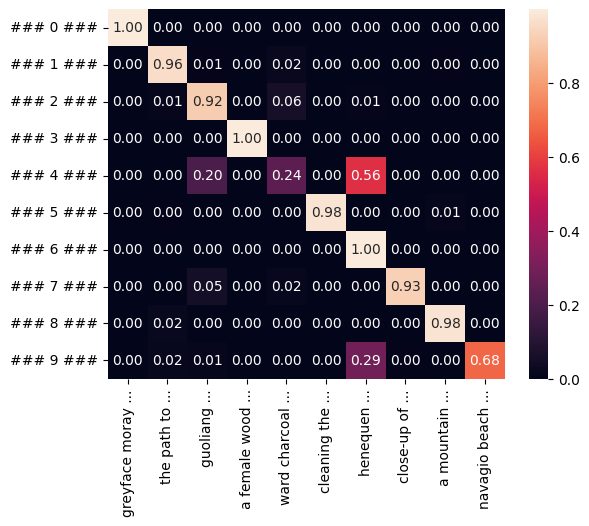

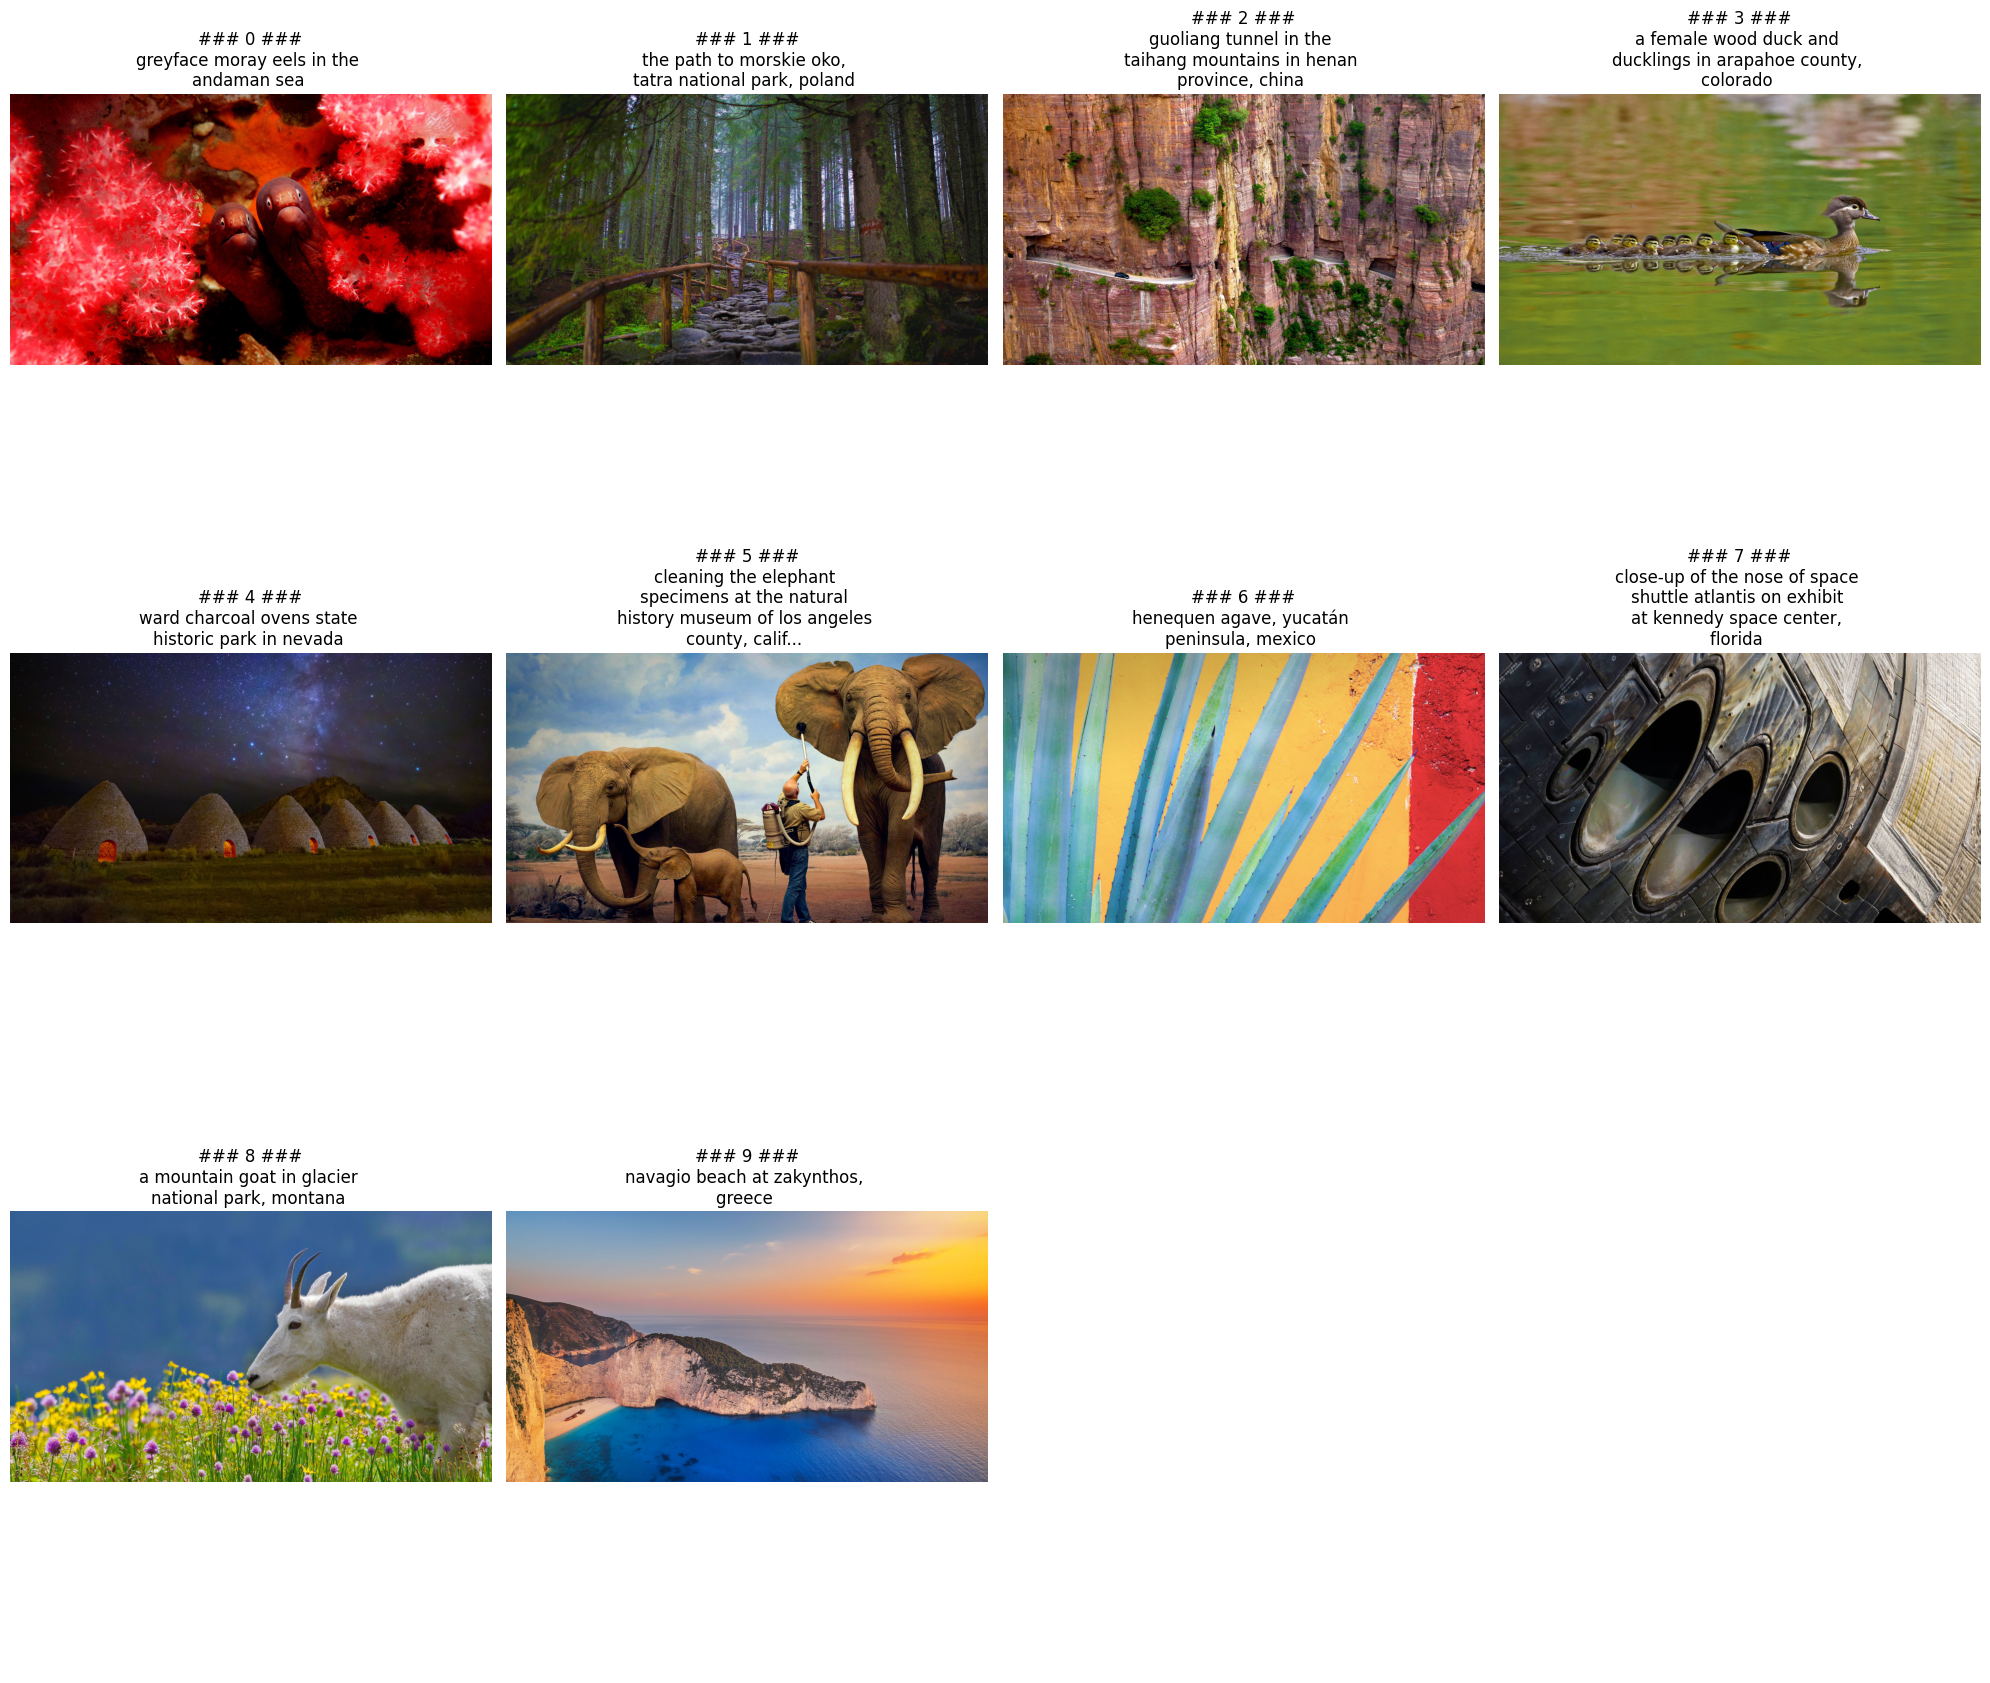

In [ ]:
if not use_image_names_as_captions:
    print('Candidate captions:')
    for i, cap in enumerate(example_captions): print(f'  ({i}) ' + cap)
sims = sims.div(sims.sum(dim=1, keepdim=True))
df = pd.DataFrame(sims.numpy(), columns=[split_string(cap, 15).split('\n')[0] + '...' for cap in example_captions], index=[f'### {i} ###' for i in range(len(example_images))])
# sns.heatmap(df, annot=True, fmt='.2f')
sns.heatmap(df, annot=True, fmt='.2f', xticklabels=df.columns, yticklabels=df.index)
plt.show()
show_images(example_images, {True : example_captions, False : ['' for c in example_images]}[use_image_names_as_captions], n_cols=4)

## **DEMO3** Interpretability demo: deep dive into a classification

Select an image from the one uploaded and let's analyze the training samples responsible for its classification with a nice interactive plot. (Works only with CC12M as multimodal dataset)

In [ ]:
# we need CC12M metadata to display training images and captions.

if not os.path.exists(f'EmbeddedCC12Mmetadata'):
    print('Downloading CC12M metadata...')
    file_name = 'CC12M_metadata.tar'
    gdown.download(f'https://drive.google.com/uc?id={cc12m_drive_keys["Metadata"]}', file_name, quiet=False)
    print(f'Extracting {file_name}...')
    subprocess.call(f"tar -xf {file_name}", shell=True)
with open('EmbeddedCC12Mmetadata/text_list.pkl', 'rb') as f:
    text_list = pickle.load(f)
with open('EmbeddedCC12Mmetadata/url_image_list.pkl', 'rb') as f:
    image_list = pickle.load(f)

In [ ]:
!pip install --q dash==2.9.0 jupyter-dash==0.4.2;

The following plot is interactive: hovering over the data points reveals samples from the CC12M dataset.

Each circle represents a specific entry in the mukltimodal dataset that contributed to the association to one of the competing captions, indicated by the color of the circle.

The size of the circle corresponds to the weight of that particular training entry in classifying the test sample towards the associated caption.

In this visualization, the caption with the largest combined area of circles is selected as the correct caption.

Clicking on a caption in the legend removes its elements from the plot, a double click removes the elements of all the other captions.

By exploring the plot, users can gain a better understanding of the relationships between the training entries and their influence on the final classification.

For instance, given a wrong classification outcome, users can identify the broken samples from the multimodal dataset responsible for it.

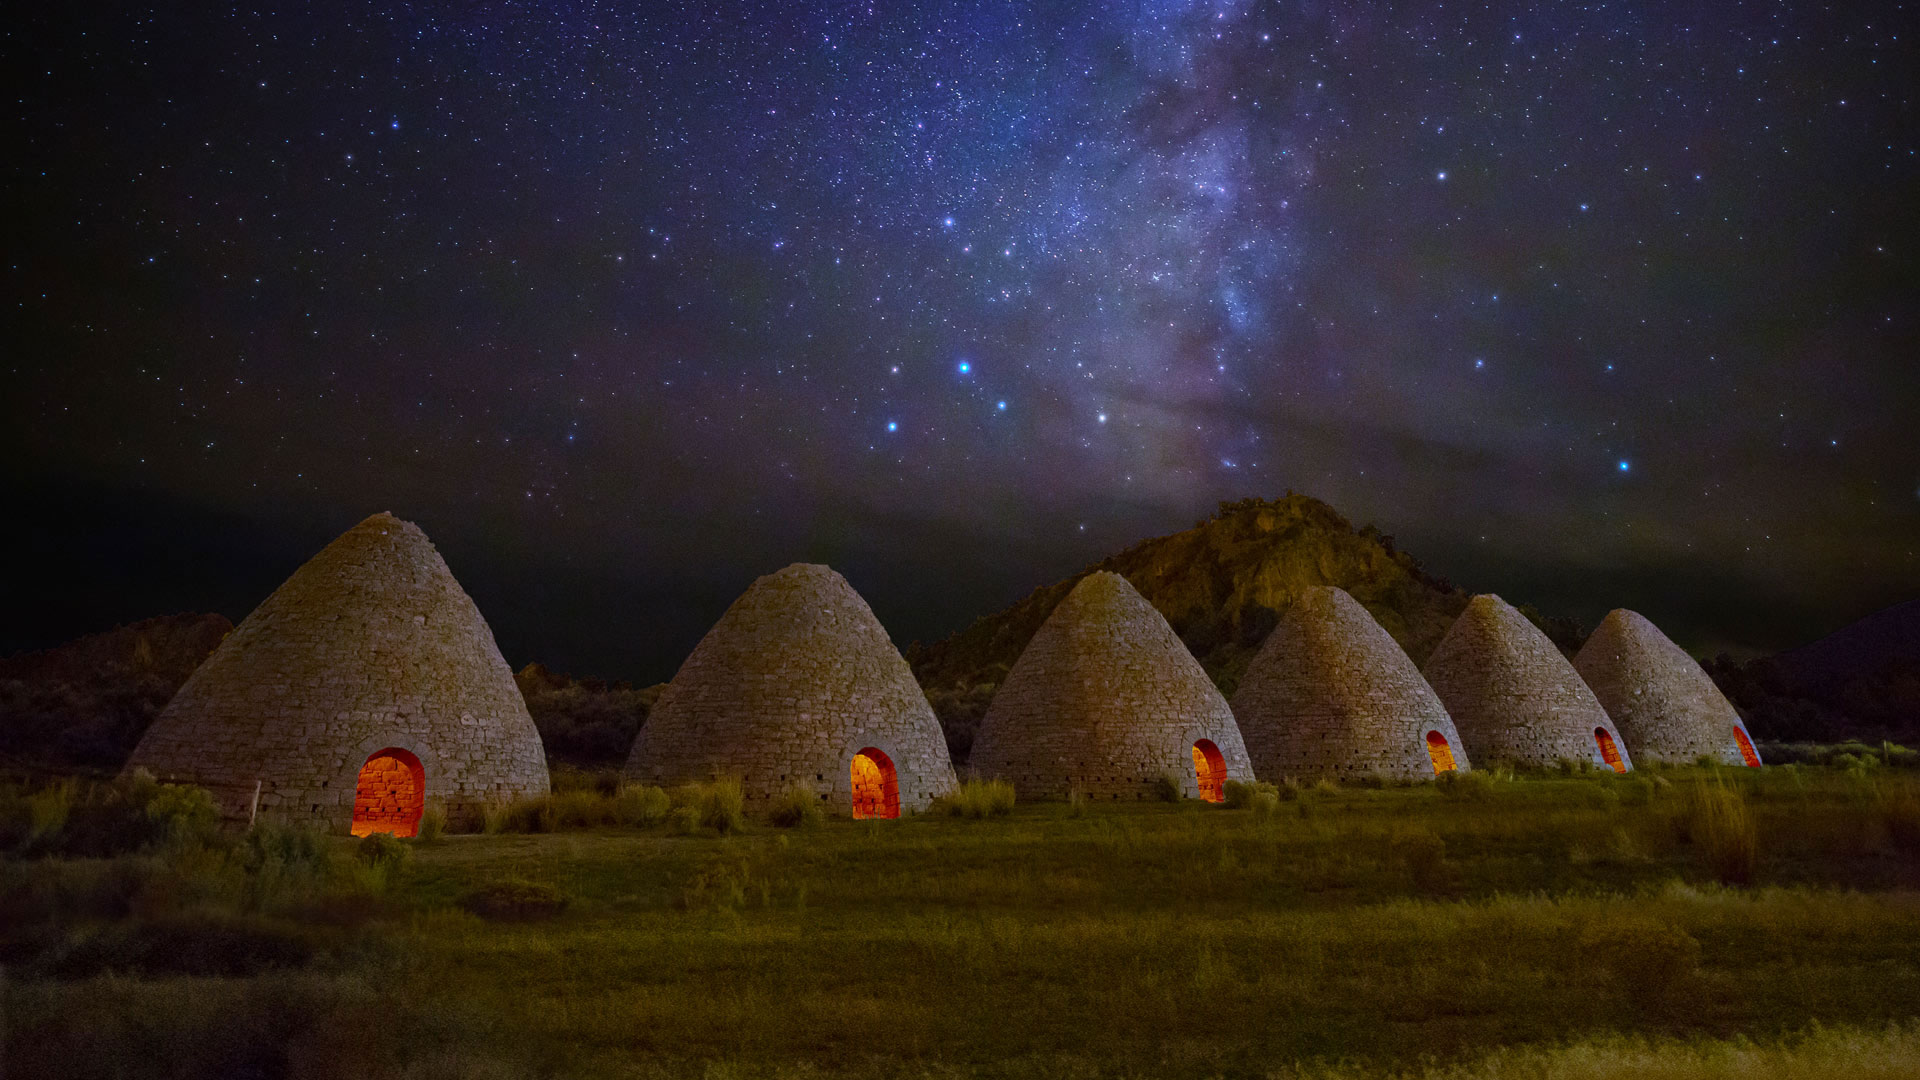

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [ ]:
# @title interactive plot

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, no_update
from IPython.display import Image as IpyImage
import plotly.graph_objects as go


image_to_deep_dive = 4  # change image here, find index in the last output
display(IpyImage(filename=f'example_images/{example_images[image_to_deep_dive]}', width=600))
show_only_common_hits = False
calculate_val_exp = False
normalize_size = True  # if false, you can compare uncertainty between images looking at the size of the points (the largest the less uncertain classification)

val_exp = {True : 8, False : 1}[calculate_val_exp]
non_zero_indices = set(torch.cat((proc_rr_imgs[image_to_deep_dive]._indices()[0], proc_rr_txts[image_to_deep_dive]._indices()[0]), dim=0).tolist())
x = []
ys = {ec : [] for ec in example_captions}
tags, image_tags = [], []
proc_rr_imgs = normalize_sparse(proc_rr_imgs ** val_exp, proc_rr_imgs[0]._nnz())
proc_rr_txts = normalize_sparse(proc_rr_txts ** val_exp, proc_rr_txts[0]._nnz())

for i in non_zero_indices:
    if (not show_only_common_hits and (proc_rr_imgs[image_to_deep_dive][i] or proc_rr_txts[image_to_deep_dive][i])) or (proc_rr_imgs[image_to_deep_dive][i] and proc_rr_txts[image_to_deep_dive][i]):
        x.append(proc_rr_imgs[image_to_deep_dive][i])
        for k, ec in enumerate(example_captions):
            ys[ec].append(proc_rr_txts[k][i])
        if select_train_dataset.split()[0] != 'CC12M':
            tags.append(train_dataset.classes[atest_labels[i]])
        else:
            tags.append(text_list[i])
            image_tags.append(image_list[i])

fig = go.Figure()

norm_size_factor = 0
sizes = []
for k, ec in enumerate(example_captions):
    size = np.array(x) * np.array(ys[ec])
    sizes.append(size)
    norm_size_factor += np.sum(size)


for k, ec in enumerate(example_captions):
    fig.add_trace(go.Scatter(
        x=np.array(x),
        y=np.array(ys[ec]),
        mode='markers',
        marker=dict(
            size=300 * sizes[k] / norm_size_factor,
            colorscale='Viridis',
            showscale=False
        ),
        text=tags,
        name=ec
    ))

fig.update_layout(
    title='Similarity between image and text',
    # xaxis_type="log",
    # yaxis_type="log",
    xaxis_title='Image similarity',
    yaxis_title='Text similarity',
    legend=dict(
        itemsizing='constant',
    )
)


fig.update_traces(hoverinfo="none", hovertemplate=None)

app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])


@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    img_src = image_tags[num]
    name = ''
    form = ''
    desc = tags[num]
    if len(desc) > 300: desc = desc[:100] + '...'

    children = [
        html.Div(children=[
            html.Img(src=img_src, style={"width": "100%"}),
            html.H2(f"{name}", style={"color": "darkblue"}),
            html.P(f"{form}"),
            html.P(f"{desc}"),
        ],
        style={'width': '400px', 'white-space': 'normal'})
    ]

    return True, bbox, children


if __name__ == "__main__":
    app.run_server(debug=True, mode='inline')

## **DEMO4** Universal classifier

In this demo an ASIF model is used to assign a label to images captured with your webcam.

The labels are elaborated from the CC12M captions.

<IPython.core.display.Javascript object>

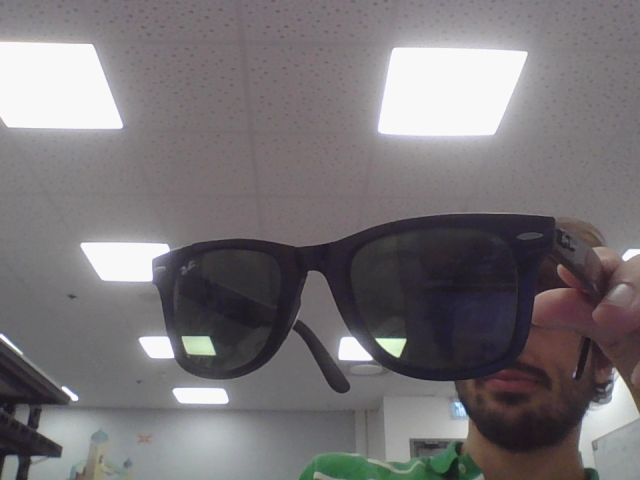

In [ ]:
# @title camera capture

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import datetime
from IPython.display import Image as disImage


def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

!rm -r /content/example_images_cam/.ipynb_checkpoints

directory = "example_images_cam"
if not os.path.exists(directory):
    os.makedirs(directory)
now = datetime.datetime.now()
filename = take_photo(f'example_images_cam/{now.strftime("%H_%M_%S")}.jpg')
# Show the image which was just taken.
display(disImage(filename))
example_images_cam = sorted(os.listdir('example_images_cam'))

In [ ]:
zimgs = image_encoder.encode(images=[Image.open(f'example_images_cam/{x}').convert('RGB') for x in example_images_cam], alr_preprocessed=False)
ztxts = text_encoder.encode(['placeholder'])
ztest_labels = [i for i in range(len(example_images_cam))]

In [ ]:
proc_rr_imgs = single_relative_represent(zimgs, aimgs)

In [ ]:
stopwords = set(['hd', 'holding', 'photography', 'go', 'stock', '<person>,', '-', '<person>', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

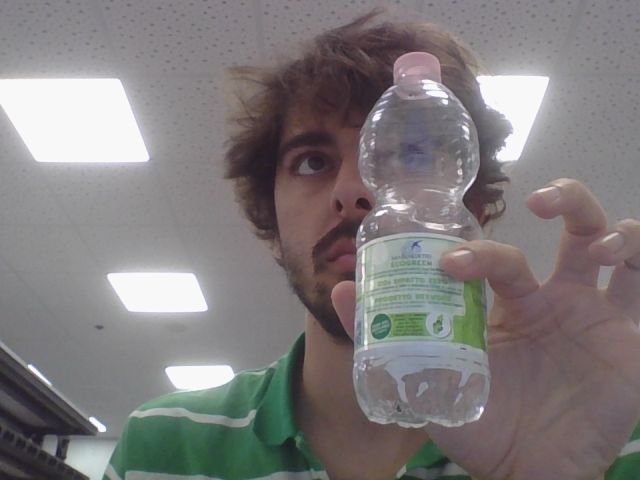

water


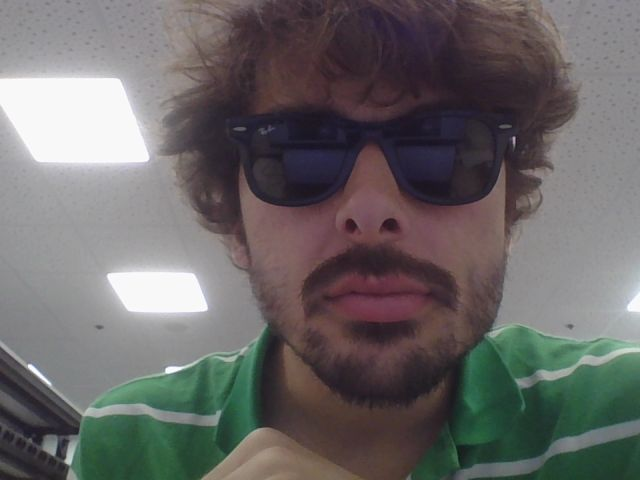

beard


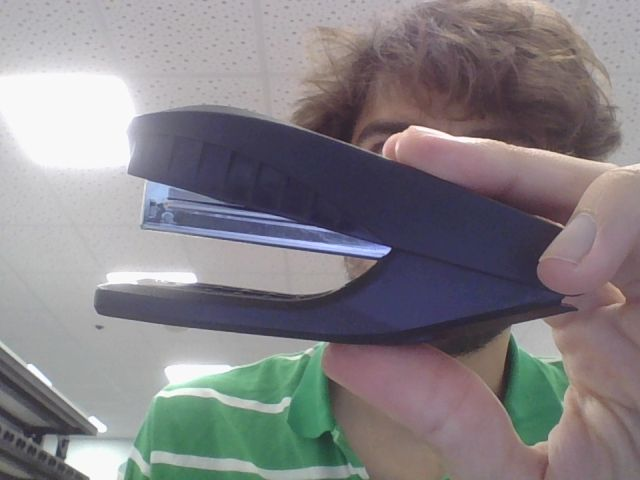

stapling papers


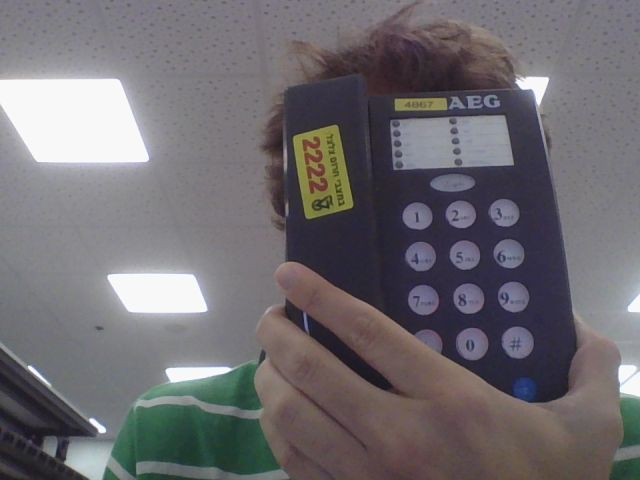

home


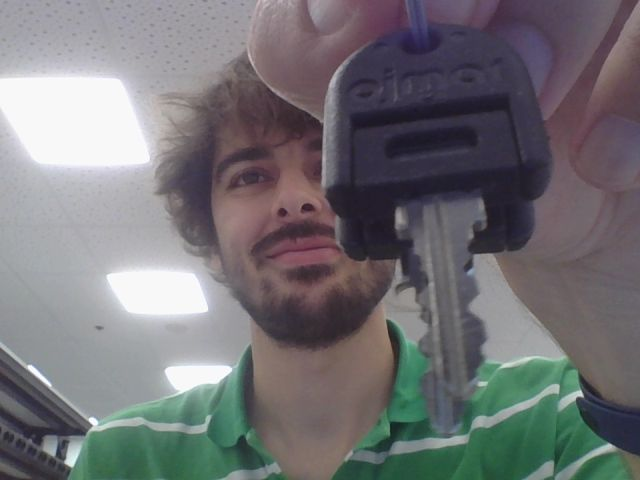

lost car keys


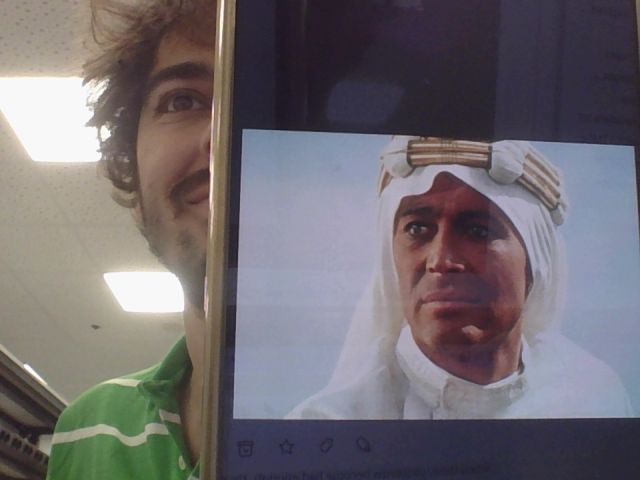

saudi


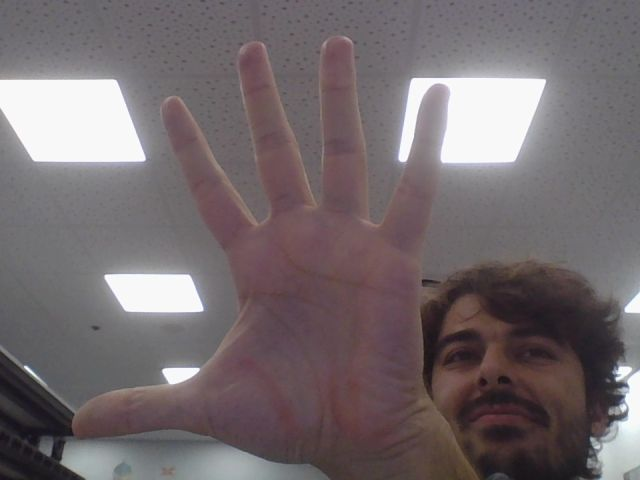

hand (5 pics)


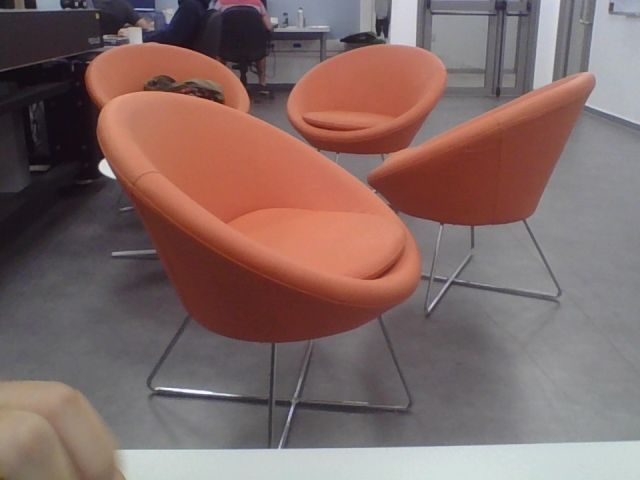

style: ikea


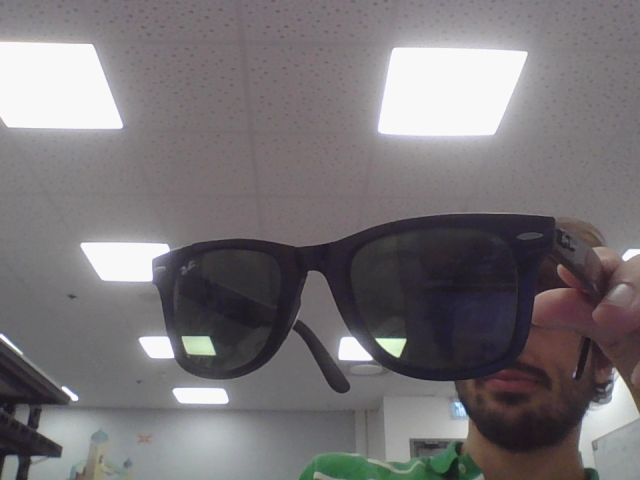

sunglasses,


In [ ]:
image_i = 7
for image_i, im_path in enumerate(example_images_cam):
    sum_values = sum(proc_rr_imgs[image_i]._values())
    max_len = 3
    top_cap = ''
    val_top_cap = 0
    pow = 8
    one_hit_per_caption = False

    counts = {}
    for i in range(1,max_len+1):
        counts[i] = {}


    for i, v in zip(proc_rr_imgs[image_i]._indices()[0].tolist(), proc_rr_imgs[image_i]._values().tolist()):
        split_string = text_list[i].lower().split()
        split_string_low = text_list[i].lower().split()
        string_tokens = set()
        for j, w in enumerate(split_string):
            for k in range(1,max_len+1):
                if set(split_string_low[j:j+k]) & stopwords or len(split_string_low[j:j+k]) != k:
                    continue
                key_c = ' '.join(split_string[j:j+k])
                if key_c not in counts[k]:
                    counts[k][key_c] = (v / sum_values) ** (pow)
                elif key_c in string_tokens:
                    continue
                else:
                    counts[k][key_c] += (v / sum_values) ** (pow)
                if counts[k][key_c] * (k ** 0.05) > val_top_cap and key_c.lower() not in stopwords:
                    val_top_cap = counts[k][key_c] * (k ** 0.05)
                    top_cap = key_c
                if one_hit_per_caption: string_tokens.add(key_c)

    display(disImage(f'example_images_cam/{example_images_cam[image_i]}'))
    print(top_cap)